# Interactions between ProTα and Histone H1.0 evolution variants

In [1]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

## Data preparation

### Topologies

#### Compact frames

In [4]:
# Loading trajectories
trajs = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    trajs[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

In [5]:
# Saving most compact frame as topology
for variant, traj in trajs.items():
    compact_frame = analyse_utils.compact_frame(traj)
    compact_frame.save_pdb(f'data/{variant}.pdb')

#### Merging

In [6]:
# Loading topologies
H10_vars = {}
ProTa = None
data_path = 'data'
for file in os.listdir(data_path):
    if '.pdb' in file:
        traj = md.load(f'{data_path}/{file}')

        id = file[:-4]
        if ('H1-0_VAR' in id) and ('PROTA_WT' not in id):
            H10_vars[id] = traj

        elif 'PROTA_WT' == id:
            ProTa = traj

print(H10_vars.keys())

dict_keys(['H1-0_VAR_k0.14', 'H1-0_VAR_k0.36', 'H1-0_VAR_k0.46', 'H1-0_VAR_k0.30', 'H1-0_VAR_k0.70', 'H1-0_VAR_k0.27', 'H1-0_VAR_k0.75', 'H1-0_VAR_k0.60', 'H1-0_VAR_k0.65', 'H1-0_VAR_k0.55', 'H1-0_VAR_k0.50', 'H1-0_VAR_k0.40', 'H1-0_VAR_k0.07', 'H1-0_VAR_k0.11'])


In [7]:
# Making sets of topologies
twochain_sets = [[H10_var, ProTa] for H10_var in H10_vars.values()]

In [8]:
# Translating topologies
for tc_set  in twochain_sets:
    translate_x = 10 # nm
    translate_y = 0 # nm
    translate_z = 0 # nm
    for i, traj in enumerate(tc_set):
        traj.center_coordinates()
        traj.xyz += [translate_x*i, translate_y*i, translate_z*i]

In [9]:
# Merging topologies
boxlength = 25 # nm
tc_merges = [simulate_utils.merge_topologies(tc_set, boxlength=boxlength) for tc_set in twochain_sets]
for traj in tc_merges:
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

In [10]:
# Saving merged topologies
for traj, H10_var_id in zip(tc_merges, H10_vars.keys()):
    filename = f'data/{H10_var_id}_PROTA_WT_{boxlength}nm.pdb'
    traj.save(filename)

## Analysis

### Single chain

In [32]:
# Loading trajectories
traj = {}
resultsdir = "results/single_chain/default"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    traj[variant] = md.load_dcd(f"{dir}/traj.dcd", f"{dir}/top.pdb")

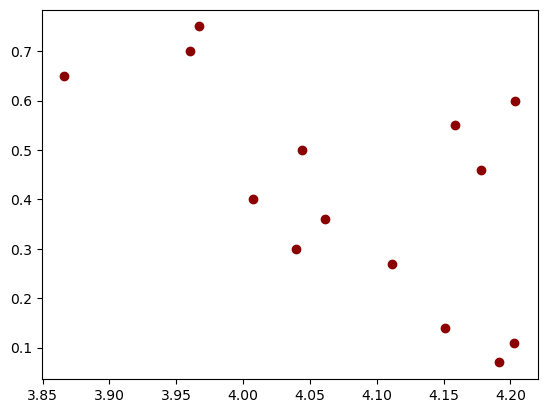

In [14]:
# Checking Rg kappa range
kappas = [float(var[-4:]) for var in traj]
rgs = [analyse_utils.compute_rg(t) for t in traj.values()]
mean_rgs = [rg.mean() for rg in rgs]
data = pd.DataFrame({'kappa': kappas, 'Rg': rgs, '<Rg>': mean_rgs}, index=traj.keys())

plt.scatter(data['<Rg>'], data['kappa'], color='darkred')

In [18]:
# Loading evolution data files
minevo_1 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_1/evolution.pkl')
minevo_2 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_2/evolution.pkl')
minevo_3 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_3/evolution.pkl')
minevo_4 = pd.read_pickle('../idpevo_h1-0/results/francesco_algorithm/0_4/evolution.pkl')
maxevo = pd.read_pickle(  '../idpevo_h1-0/results/francesco_algorithm/10/evolution.pkl')
consevo = pd.read_pickle( '../idpevo_h1-0/results/francesco_algorithm/4.258203/evolution.pkl')
allevo = pd.concat([minevo_1, minevo_2, minevo_3, minevo_4, maxevo, consevo])

In [23]:
# Getting evo data
evo_rg = allevo[allevo.simulate]['obs'].astype(float)
evo_kappa = allevo[allevo.simulate].apply(lambda row: analyse_utils.SequenceParameters(''.join(row.fasta)).get_kappa(), axis=1)

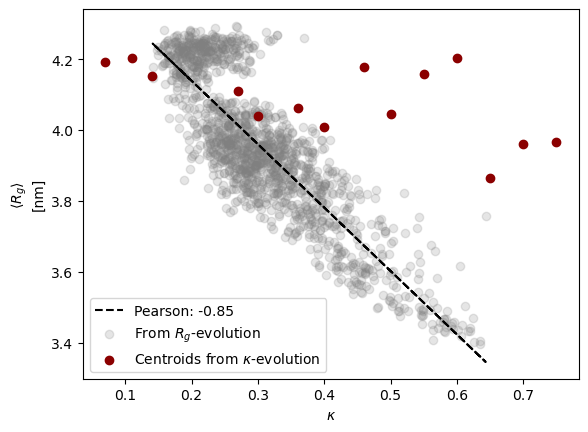

In [31]:
# Comparing Kappa evolution as a guide for Rg evolution
from scipy.stats import pearsonr

x = evo_kappa
y = evo_rg
corr, p_value = pearsonr(x, y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, x*slope+intercept, color='k', linestyle='--')

plt.scatter(x, y, alpha=0.2, color='grey')
plt.scatter(data['kappa'], data['<Rg>'], color='darkred')

plt.xlabel("$\kappa$")
plt.ylabel("$\left\langle R_g \\right\\rangle$\n[nm]")
plt.legend([f"Pearson: {corr:.2f}", "From $R_g$-evolution", "Centroids from $\kappa$-evolution"])
plt.show()


### Two chain

#### $K_d$

In [8]:
# Loading precalculated energy data
datas = []
resultsdir = "results/two_chain/ionic_240"
for variant in os.listdir(resultsdir):
    dir = f"{resultsdir}/{variant}"
    data = pd.read_csv(dir+'/interaction_energy.csv', index_col=0).sort_index()
    data['Total energy [kJ/mol]'] = data['Ashbaugh-Hatch [kJ/mol]'] + data['Debye-Hückel [kJ/mol]']
    data['kappa'] = float(variant[10:14])
    datas.append(data)
data = pd.concat(datas)
data

,Ashbaugh-Hatch [kJ/mol],Debye-Hückel [kJ/mol],Minimum interresidue distance [nm],Center of mass distance [nm],Total energy [kJ/mol],kappa
0,-6.647394,-24.409013,0.554494,1.665381,-31.056407,0.14
1,-2.877372,-32.943237,0.543063,1.489447,-35.820609,0.14
2,-4.516698,-23.277983,0.620331,1.961132,-27.794681,0.14
3,-3.899456,-25.069151,0.513256,2.230733,-28.968607,0.14
4,-3.883194,-21.928418,0.538374,2.232057,-25.811611,0.14
...,...,...,...,...,...,...
331995,-1.600219,26.729850,0.581480,1.929221,25.129631,0.98
331996,8.150937,45.641009,0.540147,1.963958,53.791946,0.98
331997,-3.652742,39.010799,0.568228,2.269190,35.358057,0.98
331998,3.130189,36.811401,0.576103,2.524335,39.941590,0.98


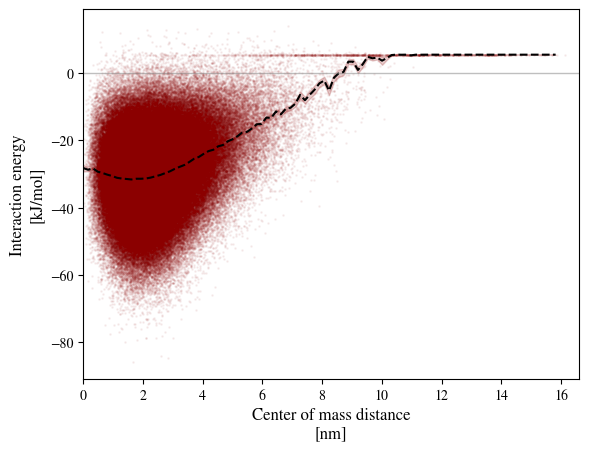

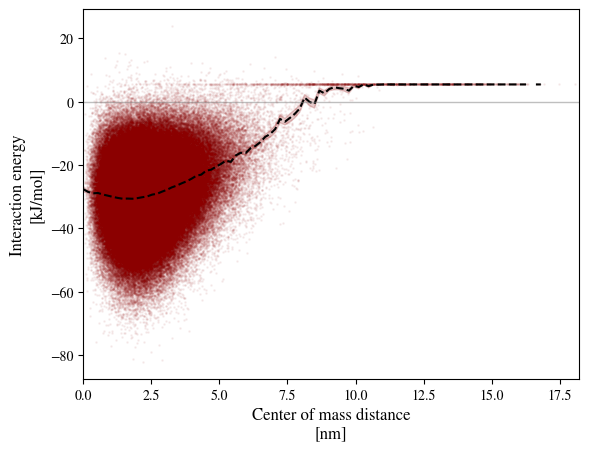

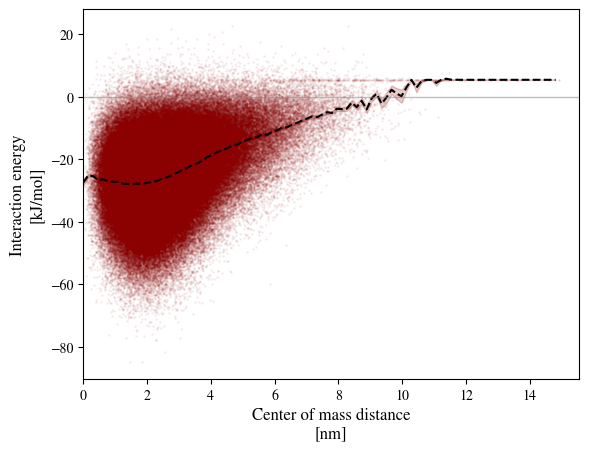

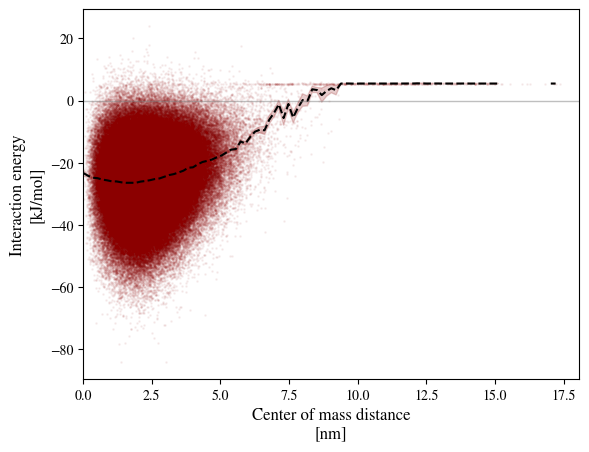

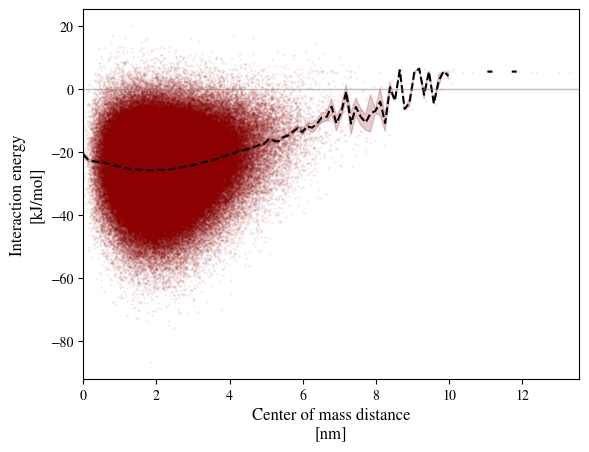

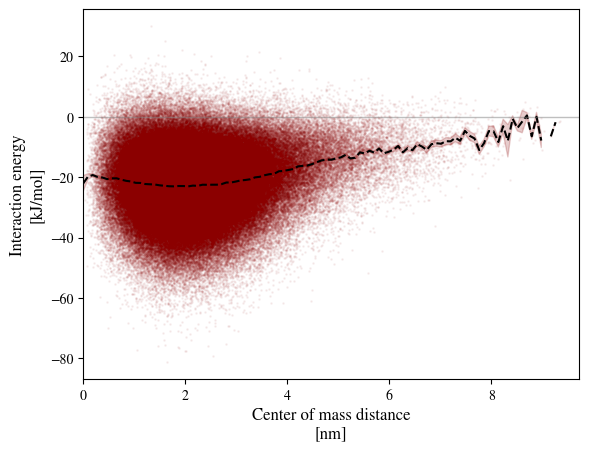

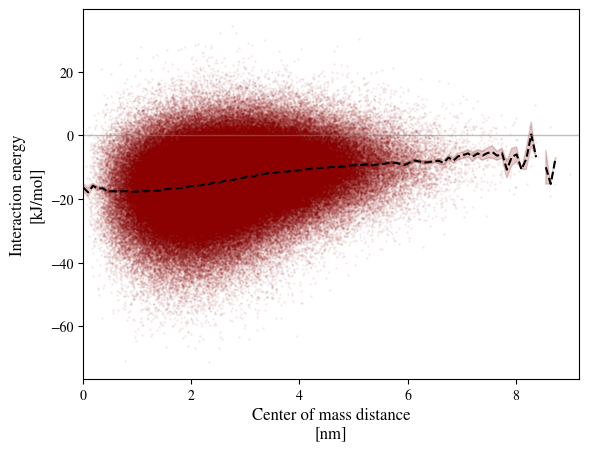

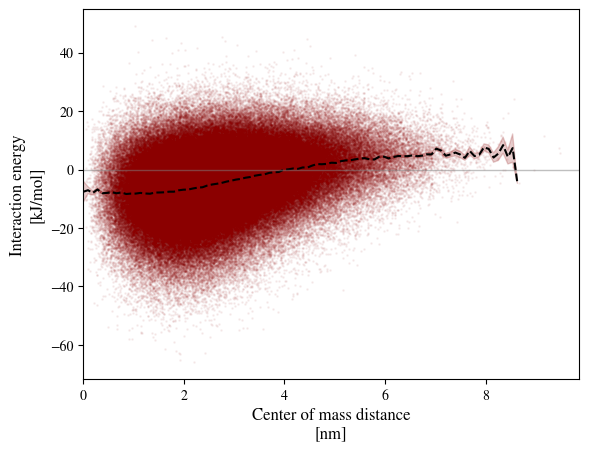

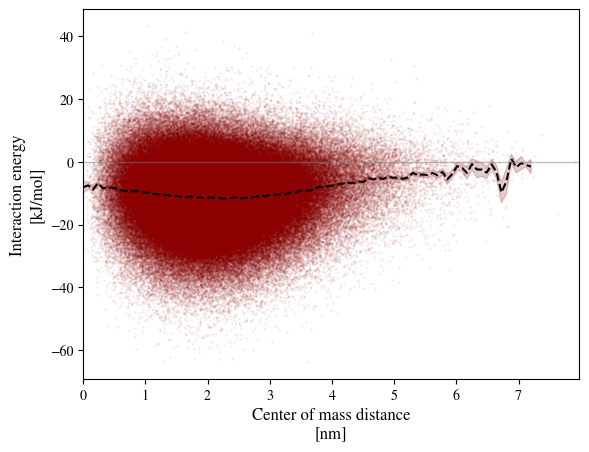

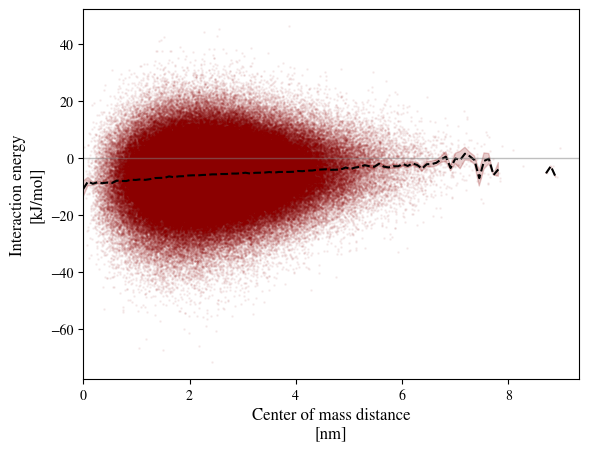

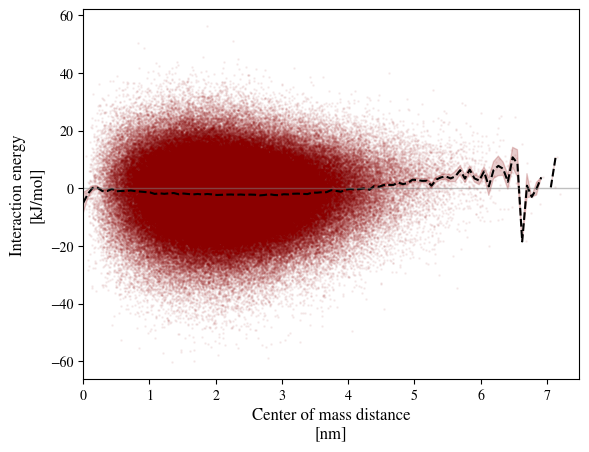

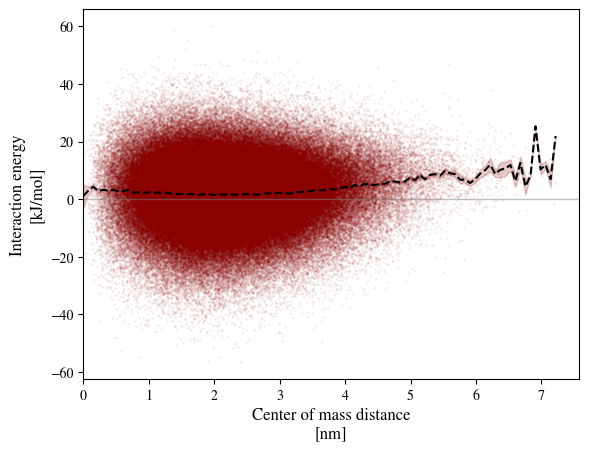

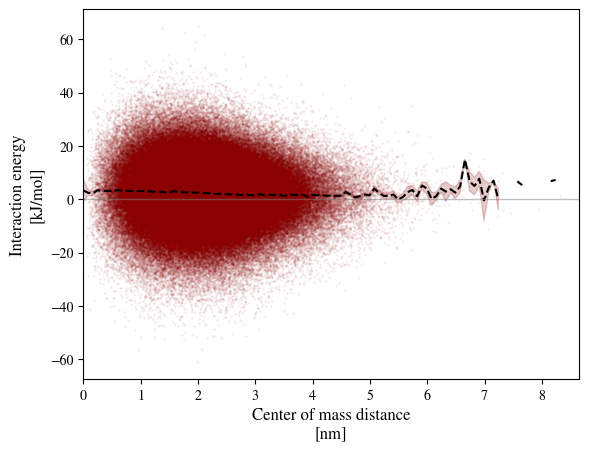

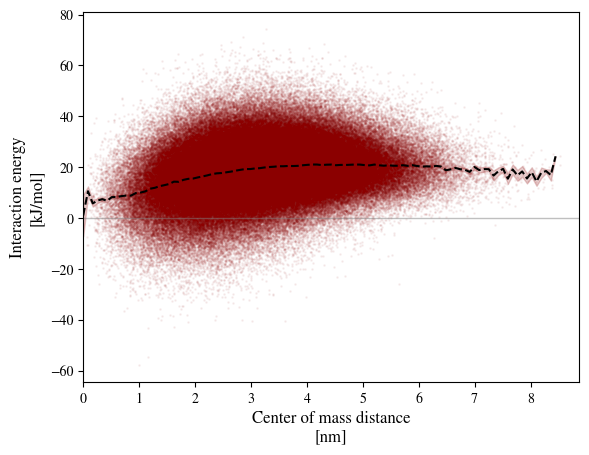

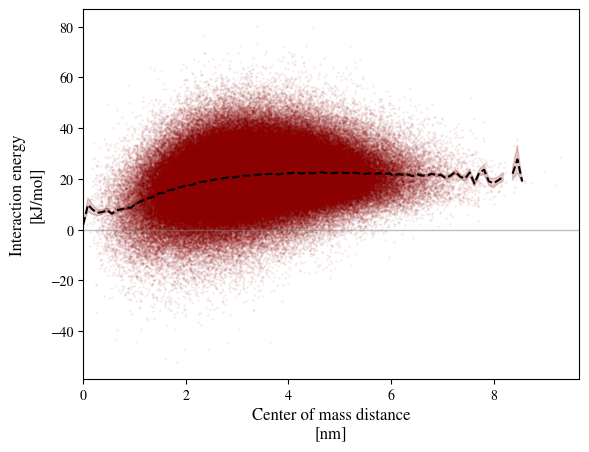

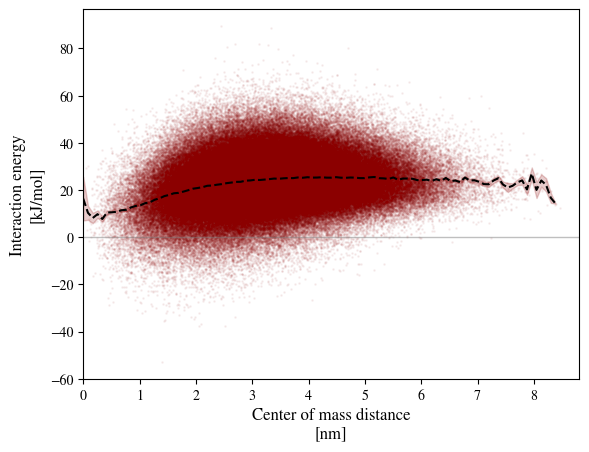

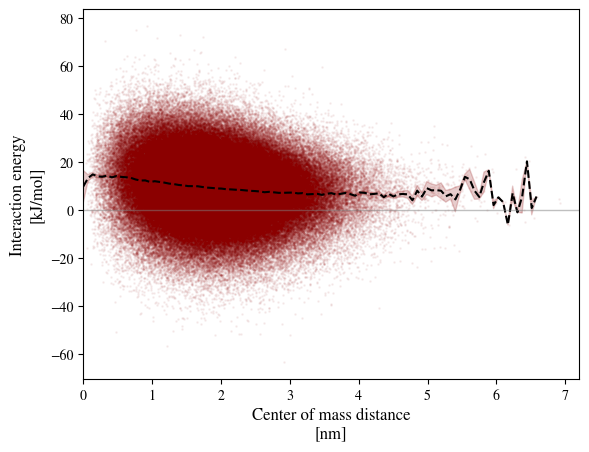

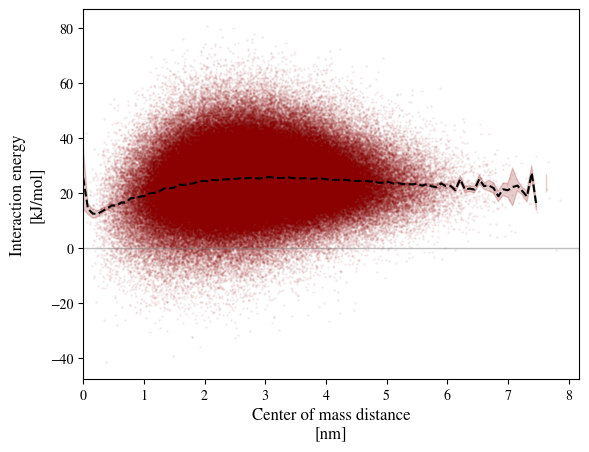

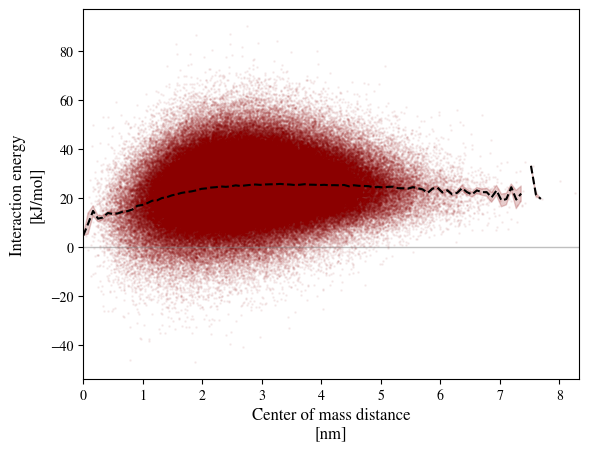

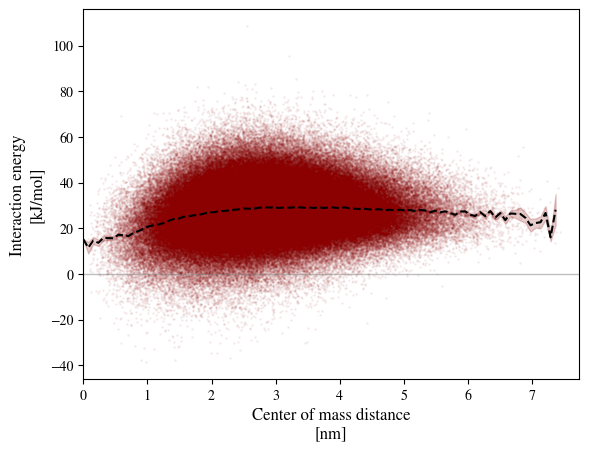

In [16]:
# Calculating Kds and assessing proper sampling
Kds = data.groupby('kappa').apply(lambda df: analyse_utils.compute_Kd(df['Total energy [kJ/mol]'], df['Center of mass distance [nm]'], 298, 100))
cutoff = 4
Kds = pd.DataFrame({
    "kappa": data.groupby('kappa').kappa.max(),
    "Kd": Kds,
    "sampled": data.groupby('kappa').apply(lambda df: any(df['Minimum interresidue distance [nm]'] > cutoff))
})

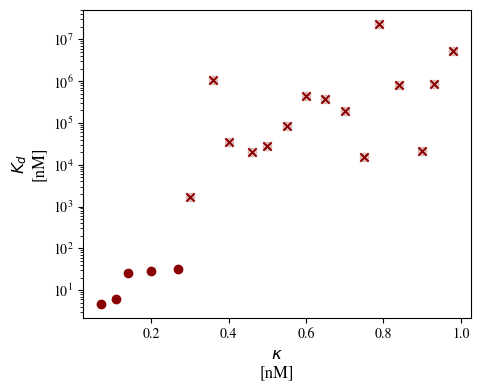

In [20]:
# Plotting results
plt.figure(figsize=(5,4))

#plt.xlim(0,1)
plt.xlabel("$\kappa$\n[nM]", fontsize=12)
plt.ylabel("$K_d$\n[nM]", fontsize=12)
plt.yscale('log')

plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Kd,  marker='x', color='darkred')
plt.scatter(Kds[~Kds.sampled].kappa, Kds[~Kds.sampled].Kd, color='darkred', alpha=0.2)
plt.scatter(Kds[Kds.sampled].kappa, Kds[Kds.sampled].Kd, color='darkred')


/tmp/ipykernel_24102/102048837.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),label='$\kappa$')


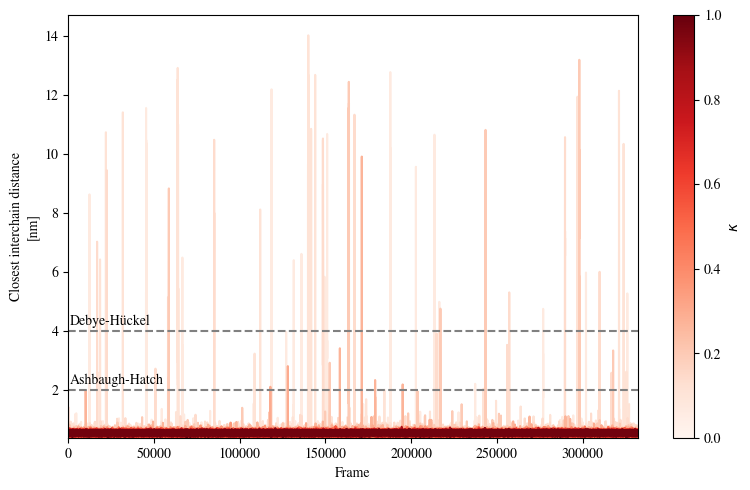

In [11]:
plt.figure(figsize=(8,5))

cmap = plt.cm.Reds
norm = plt.Normalize(vmin=0, vmax=1)
data.groupby('kappa').apply(lambda df: plt.plot(df['Minimum interresidue distance [nm]'], label=round(df['kappa'].min(),2), color=cmap(df['kappa'].min())))
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),label='$\kappa$')

plt.xlim(0, max(data.index))
plt.ylim(data['Minimum interresidue distance [nm]'].min())
plt.xlabel('Frame')
plt.ylabel('Closest interchain distance\n[nm]')

plt.hlines([simulate_utils.AH_cutoff, simulate_utils.DH_cutoff],*plt.xlim(), linestyles='--', color='grey')
plt.text(1000, simulate_utils.AH_cutoff+0.1, 'Ashbaugh-Hatch', fontsize=10, va='bottom')
plt.text(1000, simulate_utils.DH_cutoff+0.1, 'Debye-Hückel', fontsize=10, va='bottom')

plt.tight_layout()

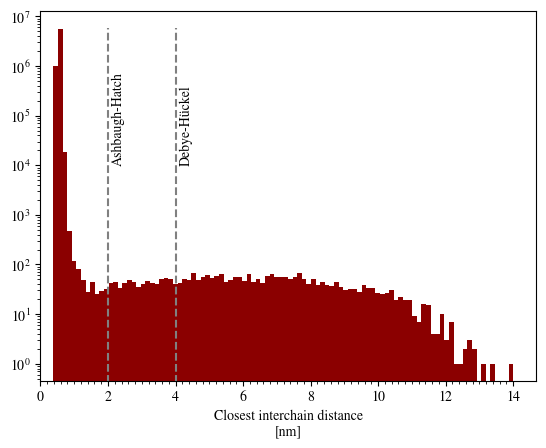

In [12]:
plt.hist(data['Minimum interresidue distance [nm]'], bins=100, color='darkred')
plt.xlabel('Closest interchain distance\n[nm]')
plt.vlines([simulate_utils.AH_cutoff, simulate_utils.DH_cutoff],*plt.ylim(), linestyles='--', color='grey')
plt.text(simulate_utils.AH_cutoff+0.1, 10000, 'Ashbaugh-Hatch', fontsize=10, va='bottom', rotation=90)
plt.text(simulate_utils.DH_cutoff+0.1, 10000, 'Debye-Hückel', fontsize=10, va='bottom', rotation=90)
plt.xlim(0)
plt.xticks(np.linspace(0,14,71), minor=True)
plt.yscale('log')

<Axes: xlabel='kappa', ylabel='Center of mass distance [nm]'>

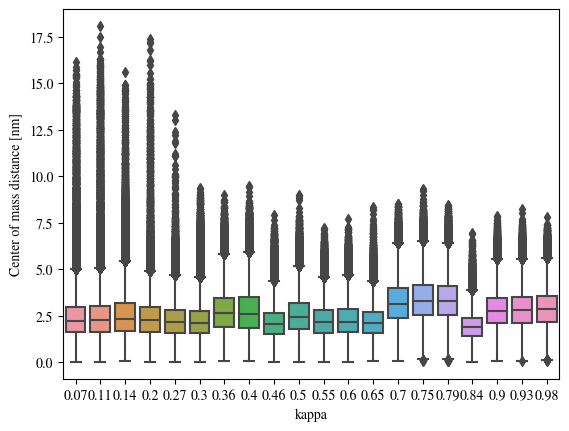

In [32]:
# Checking mean distances
import seaborn as sns
sns.boxplot(data=data, y='Center of mass distance [nm]', x='kappa')

<Axes: xlabel='kappa'>

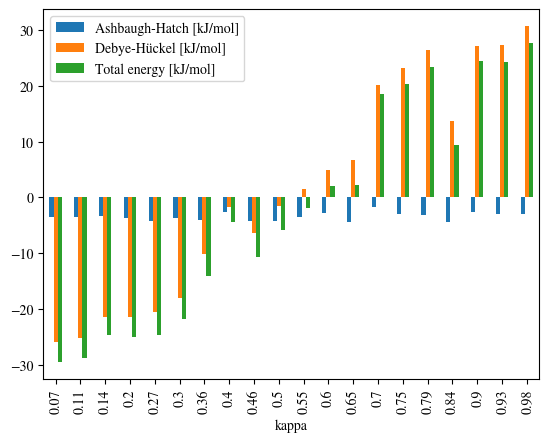

In [26]:
# Checking mean interaction energies
data[data['Minimum interresidue distance [nm]'] < 4].groupby('kappa')[['Ashbaugh-Hatch [kJ/mol]', 'Debye-Hückel [kJ/mol]', 'Total energy [kJ/mol]']].mean().plot.bar()